In [1]:
#Importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
import os
import matplotlib.pyplot as plt#visualization
from PIL import  Image
%matplotlib inline
import pandas as pd
import seaborn as sns#visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

In [2]:
telcom = pd.read_csv("Telco-Customer-Churn.csv")
#first few rows
telcom.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

# <a id='1.1'> 1. Data overview</a>

In [3]:
print ("Rows     : " ,telcom.shape[0])
print ("Columns  : " ,telcom.shape[1])
print ("\nFeatures : \n" ,telcom.columns.tolist())
print ("\nMissing values :  ", telcom.isnull().sum().values.sum())
print ("\nUnique values :  \n",telcom.nunique())

Rows     :  7043
Columns  :  21

Features : 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values :   0

Unique values :  
 customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


# <a id='2'>2. Data Manipulation</a>

In [8]:
#Data Manipulation

#Replacing spaces with null values in total charges column
telcom['TotalCharges'] = telcom["TotalCharges"].replace(" ",np.nan)

#Dropping null values from total charges column which contain .15% missing data 
telcom = telcom[telcom["TotalCharges"].notnull()]
telcom = telcom.reset_index()[telcom.columns]

#convert to float type
telcom["TotalCharges"] = telcom["TotalCharges"].astype(float)

#replace 'No internet service' to No for the following columns
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    telcom[i]  = telcom[i].replace({'No internet service' : 'No'})
    
#replace values
telcom["SeniorCitizen"] = telcom["SeniorCitizen"].replace({1:"Yes",0:"No"})

#Tenure to categorical column
def tenure_lab(telcom) :
    
    if telcom["tenure"] <= 12 :
        return "Tenure_0-12"
    elif (telcom["tenure"] > 12) & (telcom["tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (telcom["tenure"] > 24) & (telcom["tenure"] <= 48) :
        return "Tenure_24-48"
    elif (telcom["tenure"] > 48) & (telcom["tenure"] <= 60) :
        return "Tenure_48-60"
    elif telcom["tenure"] > 60 :
        return "Tenure_gt_60"
telcom["tenure_group"] = telcom.apply(lambda telcom:tenure_lab(telcom),
                                      axis = 1)

#Separating churn and non churn customers
churn     = telcom[telcom["Churn"] == "Yes"]
not_churn = telcom[telcom["Churn"] == "No"]

#Separating catagorical and numerical columns
Id_col     = ['customerID']
target_col = ["Churn"]
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]

#MonthlyCharges to categorical column
def mc_lab(telcom) :
    if telcom["MonthlyCharges"] <= 30 :
        return "MonthlyCharges_0-30"
    elif (telcom["MonthlyCharges"] > 30) & (telcom["MonthlyCharges"] <= 60 ):
        return "MonthlyCharges_30-60"
    elif (telcom["MonthlyCharges"] > 60) & (telcom["MonthlyCharges"] <= 90) :
        return "MonthlyCharges_60-90"
    elif (telcom["MonthlyCharges"] > 90) :
        return "MonthlyCharges_90-120"

telcom["mc_group"] = telcom.apply(lambda telcom:mc_lab(telcom), axis = 1)

#TotalCharges to categorical column
def tc_lab(telcom) :
    if telcom["TotalCharges"] <= 400 :
        return "TotalCharges_0-400"
    elif (telcom["TotalCharges"] > 400) & (telcom["TotalCharges"] <= 1400 ):
        return "TotalCharges_400-1400"
    elif (telcom["TotalCharges"] > 1400) & (telcom["TotalCharges"] <= 4000) :
        return "TotalCharges_1400-4000"
    elif (telcom["TotalCharges"] > 4000) :
        return "TotalCharges_4000-9000"
    
telcom["tc_group"] = telcom.apply(lambda telcom:tc_lab(telcom), axis = 1)

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64

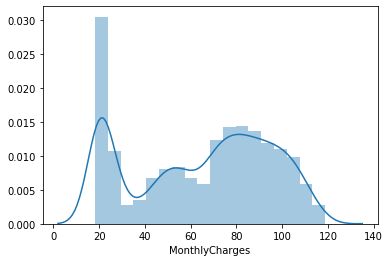

In [9]:
sns.distplot(telcom["MonthlyCharges"])
telcom["MonthlyCharges"].describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

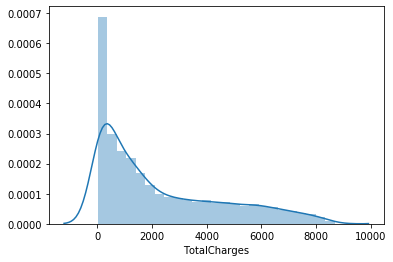

In [10]:
sns.distplot(telcom['TotalCharges'])
telcom["TotalCharges"].describe()

# <a id='3'>3. Exploratory Data Analysis (EDA)</a>

## <a id='3.1'>Customer attrition in data</a>

In [11]:
#labels
lab = telcom["Churn"].value_counts().keys().tolist()
#values
val = telcom["Churn"].value_counts().values.tolist()

trace = go.Pie(labels = lab , values = val ,
               marker = dict(colors =  [ 'royalblue' ,'lime'],
                             line = dict(color = "white",
                             width =  1.3)),
               rotation = 90, hoverinfo = "label+value+text",
               hole = .5)
layout = go.Layout(dict(title = "Customer attrition in data",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",))

data = [trace]
fig = go.Figure(data = data,layout = layout)
py.iplot(fig)

## <a id='3.2'>Variables distribution in customer attrition</a>

In [12]:
#function  for pie plot for customer attrition types
def plot_pie(column) :
    
    trace1 = go.Pie(values  = churn[column].value_counts().values.tolist(),
                    labels  = churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Churn Customers",
                    marker  = dict(line = dict(width = 2, color = "rgb(243,243,243)")),
                    hole    = .6)
    trace2 = go.Pie(values  = not_churn[column].value_counts().values.tolist(),
                    labels  = not_churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,color = "rgb(243,243,243)")),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Non churn customers")


    layout = go.Layout(dict(title = column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .15, y = .5),
                                           dict(text = "Non churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .88,y = .5)]))
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)

#function  for histogram for customer attrition types
def histogram(column) :
    trace1 = go.Histogram(x  = churn[column],
                          histnorm= "percent",
                          name = "Churn Customers",
                          marker = dict(line = dict(width = .5,
                                        color = "black")), opacity = .9) 
    
    trace2 = go.Histogram(x  = not_churn[column],
                          histnorm = "percent",
                          name = "Non churn customers",
                          marker = dict(line = dict(width = .5,
                                        color = "black")),opacity = .9)
    
    data = [trace1,trace2]
    layout = go.Layout(dict(title =column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = column,
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2),))
    fig  = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)
    
#function  for scatter plot matrix  for numerical columns in data
def scatter_matrix(df)  :
    
    df  = df.sort_values(by = "Churn" ,ascending = True)
    classes = df["Churn"].unique().tolist()
    classes
    
    class_code  = {classes[k] : k for k in range(2)}
    class_code

    color_vals = [class_code[cl] for cl in df["Churn"]]
    color_vals

    pl_colorscale = "Portland"

    pl_colorscale

    text = [df.loc[k,"Churn"] for k in range(len(df))]
    text

    trace = go.Splom(dimensions = [dict(label  = "tenure",
                                       values = df["tenure"]),
                                  dict(label  = 'MonthlyCharges',
                                       values = df['MonthlyCharges']),
                                  dict(label  = 'TotalCharges',
                                       values = df['TotalCharges'])],
                     text = text,
                     marker = dict(color = color_vals,
                                   colorscale = pl_colorscale,
                                   size = 3,
                                   showscale = False,
                                   line = dict(width = .1,
                                               color='rgb(230,230,230)')))
    axis = dict(showline  = True,
                zeroline  = False,
                gridcolor = "#fff",
                ticklen   = 4)
    
    layout = go.Layout(dict(title  = 
                            "Scatter plot matrix for Numerical columns for customer attrition",
                            autosize = False,
                            height = 800,
                            width  = 800,
                            dragmode = "select",
                            hovermode = "closest",
                            plot_bgcolor  = 'rgba(240,240,240, 0.95)',
                            xaxis1 = dict(axis),
                            yaxis1 = dict(axis),
                            xaxis2 = dict(axis),
                            yaxis2 = dict(axis),
                            xaxis3 = dict(axis),
                            yaxis3 = dict(axis),))
    data   = [trace]
    fig = go.Figure(data = data,layout = layout )
    py.iplot(fig)

#for all categorical columns plot pie
for i in cat_cols :
    plot_pie(i)

#for all categorical columns plot histogram    
for i in num_cols :
    histogram(i)

#scatter plot matrix
scatter_matrix(telcom)

## <a id='3.3'>Customer attrition in tenure groups</a>

In [13]:
#cusomer attrition in tenure groups
tg_ch  =  churn["tenure_group"].value_counts().reset_index()
tg_ch.columns  = ["tenure_group","count"]
tg_nch =  not_churn["tenure_group"].value_counts().reset_index()
tg_nch.columns = ["tenure_group","count"]

#bar - churn
trace1 = go.Bar(x = tg_ch["tenure_group"]  , y = tg_ch["count"],
                name = "Churn Customers",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)

#bar - not churn
trace2 = go.Bar(x = tg_nch["tenure_group"] , y = tg_nch["count"],
                name = "Non Churn Customers",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)

layout = go.Layout(dict(title = "Customer attrition in tenure groups",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "tenure group",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "count",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),))
data = [trace1,trace2]
fig  = go.Figure(data=data,layout=layout)
py.iplot(fig)

## <a id='3.4'>Monthly Charges and Total Charges by Tenure and Churn groups</a>

In [15]:
telcom[['MonthlyCharges', 'TotalCharges','tenure',"tenure_group"]]

#scatter plot monthly charges & total charges by tenure group

def plot_tenure_scatter(tenure_group,color) :
    tracer = go.Scatter(x = telcom[telcom["tenure_group"] == tenure_group]["MonthlyCharges"],
                        y = telcom[telcom["tenure_group"] == tenure_group]["TotalCharges"],
                        mode = "markers",marker = dict(line = dict(color = "black",
                                                                   width = .2),
                                                       size = 4 , color = color,
                                                       symbol = "diamond-dot",
                                                      ),
                        name = tenure_group,
                        opacity = .9
                       )
    return tracer

#scatter plot monthly charges & total charges by churn group
def plot_churncharges_scatter(churn,color) :
    tracer = go.Scatter(x = telcom[telcom["Churn"] == churn]["MonthlyCharges"],
                        y = telcom[telcom["Churn"] == churn]["TotalCharges"],
                        mode = "markers",marker = dict(line = dict(color = "black",
                                                                   width = .2),
                                                       size = 4 , color = color,
                                                       symbol = "diamond-dot",
                                                      ),
                        name = "Churn - " + churn,
                        opacity = .9
                       )
    return tracer

trace1 = plot_tenure_scatter("Tenure_0-12","#FF3300")
trace2 = plot_tenure_scatter("Tenure_12-24","#6666FF")
trace3 = plot_tenure_scatter("Tenure_24-48","#99FF00")
trace4 = plot_tenure_scatter("Tenure_48-60","#996600")
trace5 = plot_tenure_scatter("Tenure_gt_60","grey")
trace6 = plot_churncharges_scatter("Yes","red")
trace7 = plot_churncharges_scatter("No","blue")

data1   = [trace1,trace2,trace3,trace4,trace5] 
data2   = [trace7,trace6]

#layout
def layout_title(title) :
    layout = go.Layout(dict(title = title,
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         title = "Monthly charges",
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         title = "Total Charges",
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            height = 600
                           )
                      )
    return layout

layout1  = layout_title("Monthly Charges & Total Charges by Tenure group")
layout2  = layout_title("Monthly Charges & Total Charges by Churn group")
fig1 = go.Figure(data = data1,layout = layout1)
fig2 = go.Figure(data = data2,layout = layout2)
py.iplot(fig1)
py.iplot(fig2)

## <a id='3.5'>Average Charges by tenure groups</a>

In [16]:
avg_tgc = telcom.groupby(["tenure_group","Churn"])[["MonthlyCharges",
                                                    "TotalCharges"]].mean().reset_index()

#function for tracing 
def mean_charges(column,aggregate) :
    tracer = go.Bar(x = avg_tgc[avg_tgc["Churn"] == aggregate]["tenure_group"],
                    y = avg_tgc[avg_tgc["Churn"] == aggregate][column],
                    name = aggregate,marker = dict(line = dict(width = 1)),
                    text = "Churn"
                   )
    return tracer

#function for layout
def layout_plot(title,xaxis_lab,yaxis_lab) :
    layout = go.Layout(dict(title = title,
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = xaxis_lab,
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = yaxis_lab,
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                           )
                      )
    return layout
    

#plot1 - mean monthly charges by tenure groups
trace1  = mean_charges("MonthlyCharges","Yes")
trace2  = mean_charges("MonthlyCharges","No")
layout1 = layout_plot("Average Monthly Charges by Tenure groups",
                      "Tenure group","Monthly Charges")
data1   = [trace1,trace2]
fig1    = go.Figure(data=data1,layout=layout1)

#plot2 - mean total charges by tenure groups
trace3  = mean_charges("TotalCharges","Yes")
trace4  = mean_charges("TotalCharges","No")
layout2 = layout_plot("Average Total Charges by Tenure groups",
                      "Tenure group","Total Charges")
data2   = [trace3,trace4]
fig2    = go.Figure(data=data2,layout=layout2)

py.iplot(fig1)
py.iplot(fig2)


## <a id='3.6'>Monthly charges,total charges and tenure in customer attrition</a>

In [17]:
##copy data
tel_df = telcom.copy()


trace1 = go.Scatter3d(x = churn["MonthlyCharges"],
                      y = churn["TotalCharges"],
                      z = churn["tenure"],
                      mode = "markers",
                      name = "Churn customers",
                      text = "Id : " + churn["customerID"],
                      marker = dict(size = 1,color = "red")
                     )
trace2 = go.Scatter3d(x = not_churn["MonthlyCharges"],
                      y = not_churn["TotalCharges"],
                      z = not_churn["tenure"],
                      name = "Non churn customers",
                      text = "Id : " + not_churn["customerID"],
                      mode = "markers",
                      marker = dict(size = 1,color= "green")
                     )



layout = go.Layout(dict(title = "Monthly charges,total charges & tenure in customer attrition",
                        scene = dict(camera = dict(up=dict(x= 0 , y=0, z=0),
                                                   center=dict(x=0, y=0, z=0),
                                                   eye=dict(x=1.25, y=1.25, z=1.25)),
                                     xaxis  = dict(title = "monthly charges",
                                                   gridcolor='rgb(255, 255, 255)',
                                                   zerolinecolor='rgb(255, 255, 255)',
                                                   showbackground=True,
                                                   backgroundcolor='rgb(230, 230,230)'),
                                     yaxis  = dict(title = "total charges",
                                                   gridcolor='rgb(255, 255, 255)',
                                                   zerolinecolor='rgb(255, 255, 255)',
                                                   showbackground=True,
                                                   backgroundcolor='rgb(230, 230,230)'
                                                  ),
                                     zaxis  = dict(title = "tenure",
                                                   gridcolor='rgb(255, 255, 255)',
                                                   zerolinecolor='rgb(255, 255, 255)',
                                                   showbackground=True,
                                                   backgroundcolor='rgb(230, 230,230)'
                                                  )
                                    ),
                        height = 700,
                       )
                  )
                  

data = [trace1,trace2]
fig  = go.Figure(data = data,layout = layout)
py.iplot(fig)

# <a id='4'>4. Data preprocessing</a>

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#customer id col
Id_col     = ['customerID']
#Target columns
target_col = ["Churn"]
#categorical columns
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
# num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = telcom.nunique()[telcom.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    telcom[i] = le.fit_transform(telcom[i])
    
#Duplicating columns for multi value columns
telcom = pd.get_dummies(data = telcom,columns = multi_cols )

# #Scaling Numerical columns
# std = StandardScaler()
# scaled = std.fit_transform(telcom[num_cols])
# scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_telcom_og = telcom.copy()
# telcom = telcom.drop(columns = num_cols,axis = 1)
# telcom = telcom.merge(scaled,left_index=True,right_index=True,how = "left")

# telcom.drop(['MonthlyCharges', 'TotalCharges','tenure'], axis=1, inplace=True)


## <a id='3.7'>Variable Summary</a>

In [19]:
summary = (df_telcom_og[[i for i in df_telcom_og.columns if i not in Id_col]].
           describe().transpose().reset_index())

summary = summary.rename(columns = {"index" : "feature"})
summary = np.around(summary,3)

val_lst = [summary['feature'], summary['count'],
           summary['mean'],summary['std'],
           summary['min'], summary['25%'],
           summary['50%'], summary['75%'], summary['max']]

trace  = go.Table(header = dict(values = summary.columns.tolist(),
                                line = dict(color = ['#506784']),
                                fill = dict(color = ['#119DFF']),
                               ),
                  cells  = dict(values = val_lst,
                                line = dict(color = ['#506784']),
                                fill = dict(color = ["lightgrey",'#F5F8FF'])
                               ),
                  columnwidth = [200,60,100,100,60,60,80,80,80])
layout = go.Layout(dict(title = "Variable Summary"))
figure = go.Figure(data=[trace],layout=layout)
py.iplot(figure)


## <a id='3.8'>Correlation Matrix</a>

In [20]:
#correlation
correlation = telcom.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix for variables",
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data = [trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

## <a id='3.9'>Principal Component Analysis</a>

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

X = telcom[[i for i in telcom.columns if i not in Id_col + target_col]]
Y = telcom[target_col + Id_col]

principal_components = pca.fit_transform(X)
pca_data = pd.DataFrame(principal_components,columns = ["PC1","PC2"])
pca_data = pca_data.merge(Y,left_index=True,right_index=True,how="left")
pca_data["Churn"] = pca_data["Churn"].replace({1:"Churn",0:"Not Churn"})

def pca_scatter(target,color) :
    tracer = go.Scatter(x = pca_data[pca_data["Churn"] == target]["PC1"] ,
                        y = pca_data[pca_data["Churn"] == target]["PC2"],
                        name = target,mode = "markers",
                        marker = dict(color = color,
                                      line = dict(width = .5),
                                      symbol =  "diamond-open"),
                        text = ("Customer Id : " + 
                                pca_data[pca_data["Churn"] == target]['customerID'])
                       )
    return tracer

layout = go.Layout(dict(title = "Visualising data with principal components",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "principal component 1",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "principal component 2",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        height = 600
                       )
                  )
trace1 = pca_scatter("Churn",'red')
trace2 = pca_scatter("Not Churn",'royalblue')
data = [trace2,trace1]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

In [22]:
#Explained Variance
pca.explained_variance_ratio_

# first principal component contains 34.45% of the variance 
# and the second principal component contains 15.53% of the variance. 
# Together, the two components contain 49.98% of the information.

array([9.99860062e-01, 1.22189552e-04])

## <a id='3.10'>Binary variables distribution in customer attrition(Radar Chart)</a>

In [23]:
#separating binary columns
bi_cs = telcom.nunique()[telcom.nunique() == 2].keys()
dat_rad = telcom[bi_cs]

#plotting radar chart for churn and non churn customers(binary variables)
def plot_radar(df,aggregate,title) :
    data_frame = df[df["Churn"] == aggregate] 
    data_frame_x = data_frame[bi_cs].sum().reset_index()
    data_frame_x.columns  = ["feature","yes"]
    data_frame_x["no"]    = data_frame.shape[0]  - data_frame_x["yes"]
    data_frame_x  = data_frame_x[data_frame_x["feature"] != "Churn"]
    
    #count of 1's(yes)
    trace1 = go.Scatterpolar(r = data_frame_x["yes"].values.tolist(),
                             theta = data_frame_x["feature"].tolist(),
                             fill  = "toself",name = "count of 1's",
                             mode = "markers+lines",
                             marker = dict(size = 5)
                            )
    #count of 0's(No)
    trace2 = go.Scatterpolar(r = data_frame_x["no"].values.tolist(),
                             theta = data_frame_x["feature"].tolist(),
                             fill  = "toself",name = "count of 0's",
                             mode = "markers+lines",
                             marker = dict(size = 5)
                            ) 
    layout = go.Layout(dict(polar = dict(radialaxis = dict(visible = True,
                                                           side = "counterclockwise",
                                                           showline = True,
                                                           linewidth = 2,
                                                           tickwidth = 2,
                                                           gridcolor = "white",
                                                           gridwidth = 2),
                                         angularaxis = dict(tickfont = dict(size = 10),
                                                            layer = "below traces"
                                                           ),
                                         bgcolor  = "rgb(243,243,243)",
                                        ),
                            paper_bgcolor = "rgb(243,243,243)",
                            title = title,height = 700))
    
    data = [trace2,trace1]
    fig = go.Figure(data=data,layout=layout)
    py.iplot(fig)

#plot
plot_radar(dat_rad,1,"Churn -  Customers")
plot_radar(dat_rad,0,"Non Churn - Customers")

# <a id='5'>5. Model Building</a>
## <a id='5.1'>5.1. Baseline Model</a>

LogisticRegression(multi_class='ovr', n_jobs=1, solver='liblinear')

 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1268
           1       0.67      0.51      0.58       490

    accuracy                           0.79      1758
   macro avg       0.75      0.71      0.72      1758
weighted avg       0.78      0.79      0.78      1758

Accuracy   Score :  0.7923777019340159
Area under curve :  0.7058118199961372 



C:\Users\User\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



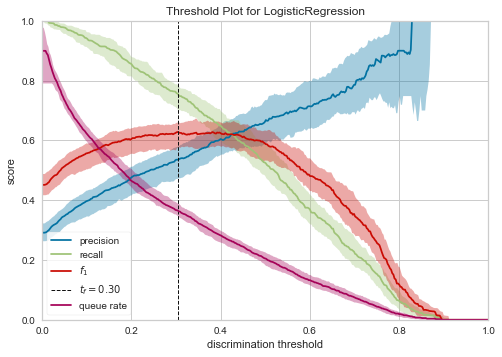

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score
from yellowbrick.classifier import DiscriminationThreshold
#splitting train and test data 
train,test = train_test_split(telcom,test_size = .25 ,random_state = 111)
    
##seperating dependent and independent variables
cols    = [i for i in telcom.columns if i not in Id_col + target_col]
train_X = train[cols]
train_Y = train[target_col]
test_X  = test[cols]
test_Y  = test[target_col]

#Function attributes
#dataframe     - processed dataframe
#Algorithm     - Algorithm used 
#training_x    - predictor variables dataframe(training)
#testing_x     - predictor variables dataframe(testing)
#training_y    - target variable(training)
#training_y    - target variable(testing)
#cf - ["coefficients","features"](cooefficients for logistic 
                                 #regression,features for tree based models)

#threshold_plot - if True returns threshold plot for model
    
def telecom_churn_prediction(algorithm,training_x,testing_x,
                             training_y,testing_y,cols,cf,threshold_plot) :
    
    #model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    #coeffs
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df     = pd.DataFrame(cols)
    coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix ,
                        x = ["Not churn","Churn"],
                        y = ["Not churn","Churn"],
                        showscale  = False,colorscale = "Picnic",
                        name = "matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    #plot coeffs
    trace4 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Picnic",
                                  line = dict(width = .6,color = "black")))
    
    #subplots
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver operating characteristic',
                                            'Feature Importances'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    fig.append_trace(trace4,2,1)
    
    fig['layout'].update(showlegend=False, title="Model performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis3"].update(dict(showgrid = True,tickfont = dict(size = 10),
                                        tickangle = 90))
    py.iplot(fig)
    
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()
        
logit  = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

telecom_churn_prediction(logit,train_X,test_X,train_Y,test_Y,
                         cols,"coefficients",threshold_plot = True)

## <a id='5.7'>Vizualising a decision tree from random forest classifier</a>

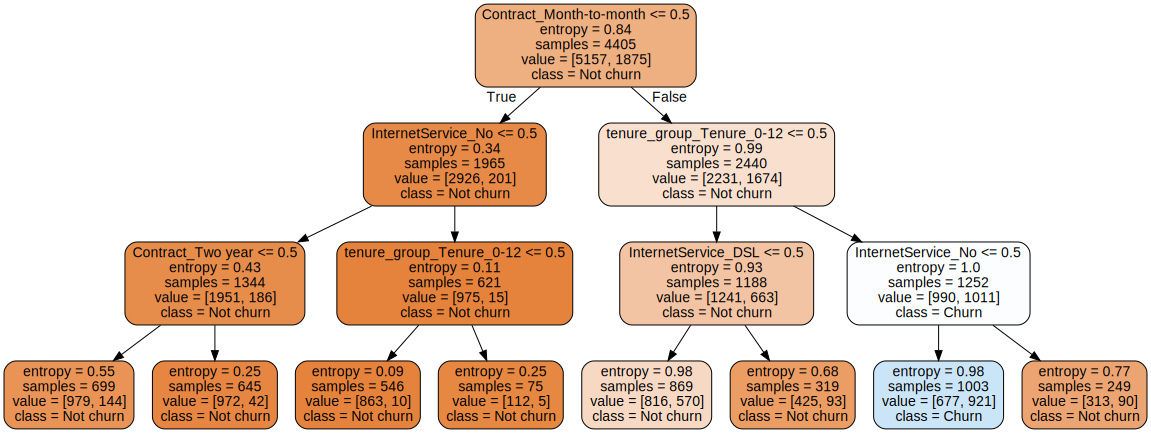

RandomForestClassifier(criterion='entropy', max_depth=3)

 Classification report : 
               precision    recall  f1-score   support

           0       0.79      0.95      0.86      1268
           1       0.71      0.34      0.46       490

    accuracy                           0.78      1758
   macro avg       0.75      0.64      0.66      1758
weighted avg       0.77      0.78      0.75      1758

Accuracy   Score :  0.7775881683731513
Area under curve :  0.6429681967424193 



C:\Users\User\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



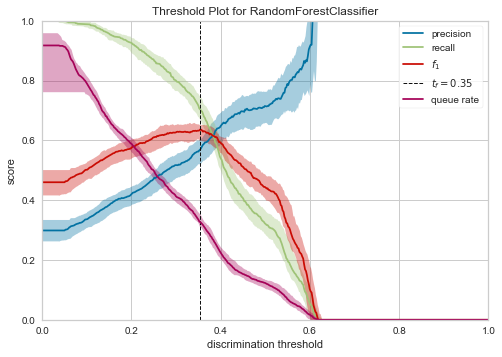

In [27]:
from sklearn.ensemble import RandomForestClassifier

#function attributes
#columns  - column used
#nf_estimators   - The number of trees in the forest.
#estimated_tree  - tree number to be displayed
#maximum_depth   - depth of the tree
#criterion_type  - split criterion type ["gini" or "entropy"]
#Model performance - prints performance of model

def plot_tree_randomforest(columns,nf_estimators,
                           estimated_tree,maximum_depth,
                           criterion_type,model_performance = None) :
    
    dataframe = df_telcom_og[columns + target_col].copy()
    
    #train and test datasets
    rf_x     = dataframe[[i for i in columns if i not in target_col]]
    rf_y     = dataframe[target_col]
    
    #random forest classifier
    rfc   = RandomForestClassifier(n_estimators = nf_estimators,
                                   max_depth = maximum_depth,
                                   criterion = criterion_type,
                                  )
    rfc.fit(rf_x,rf_y)
    
    estimated_tree = rfc.estimators_[estimated_tree]
    
    graph = Source(tree.export_graphviz(estimated_tree,out_file=None,
                                        rounded=True,proportion = False,
                            feature_names = columns, 
                            precision  = 2,
                            class_names=["Not churn","Churn"],
                            filled = True))
    display(graph)
    
    #model performance
    if model_performance == True :
        telecom_churn_prediction(rfc,
                                 rf_x,test_X[columns],
                                 rf_y,test_Y,
                                 columns,"features",threshold_plot = True)
        

cols1 = [ i for i in train_X.columns if i not in target_col + Id_col] 
plot_tree_randomforest(cols1,100,99,3,"entropy",True)

## <a id='5.8'>5.8. A random forest classifier.</a>
* A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement .
* Below are the trees produced by random forest model with 10 estimated trees with maximum depth of three  for each tree. Each tree produced is slightly different from other.

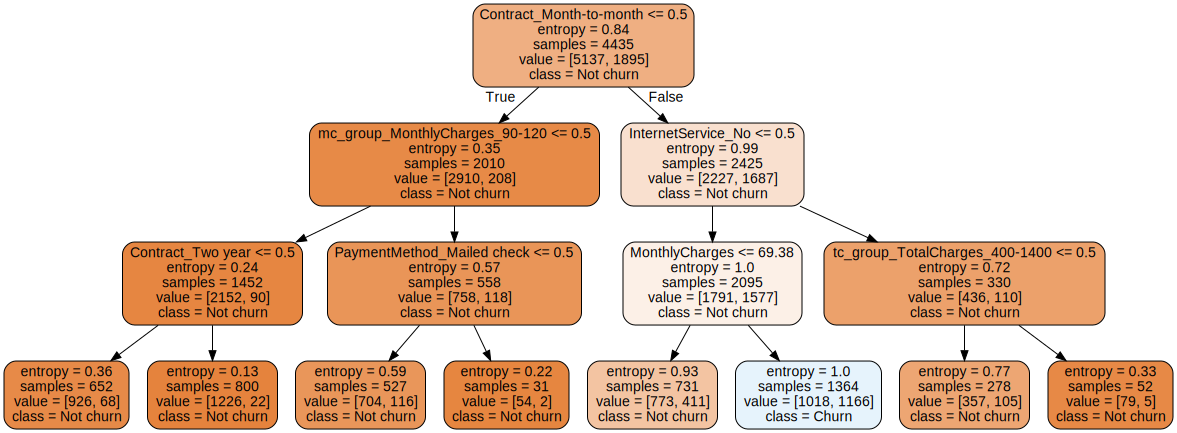

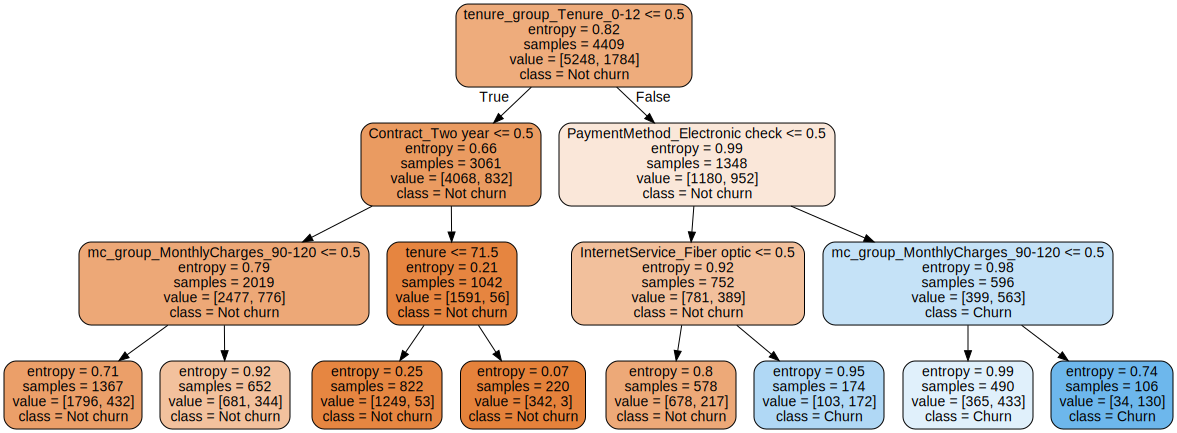

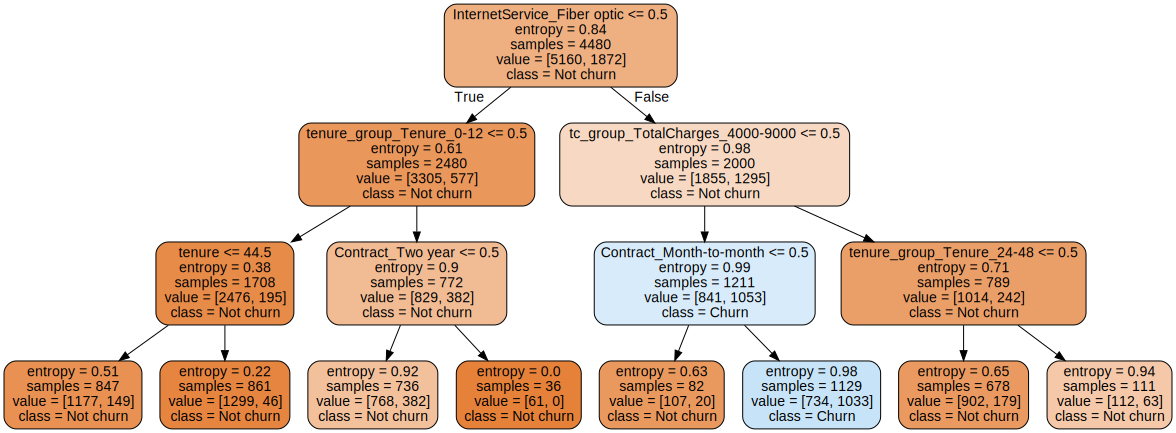

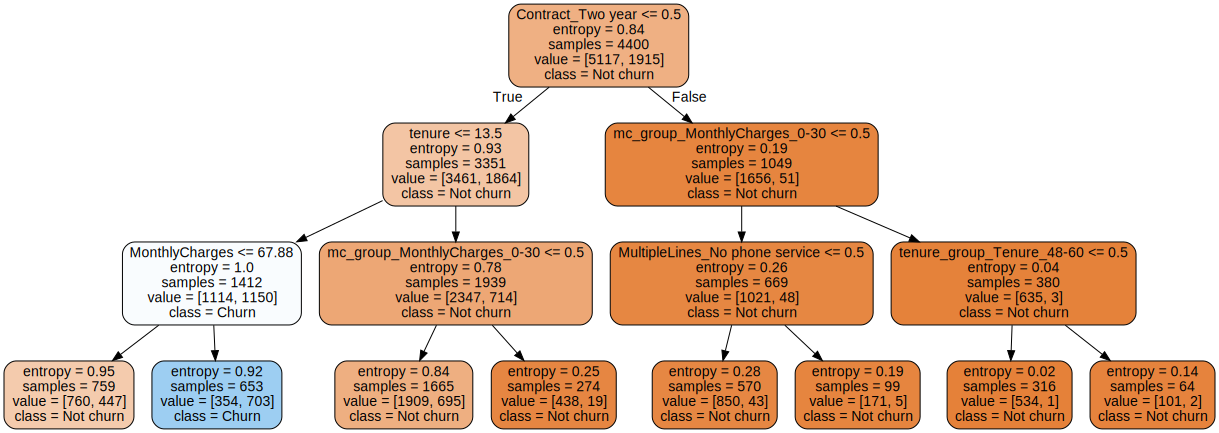

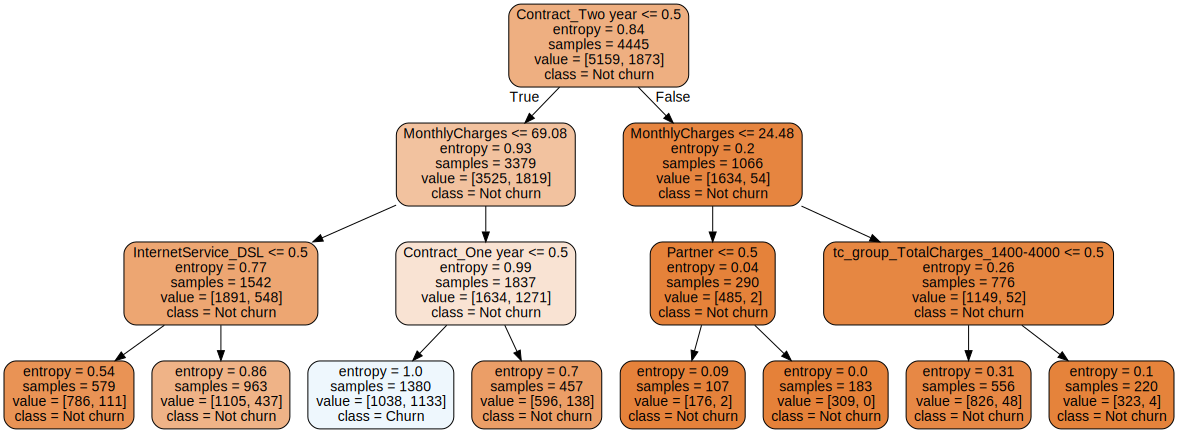

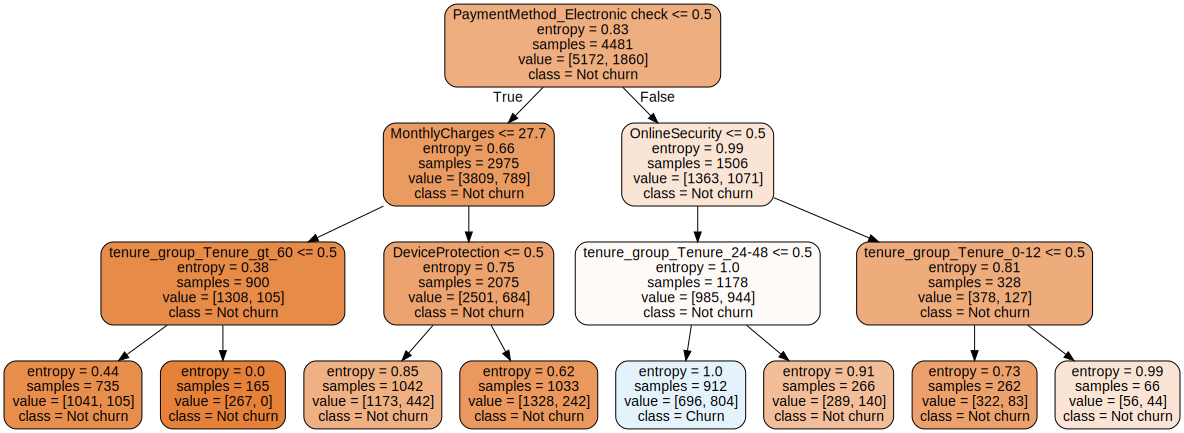

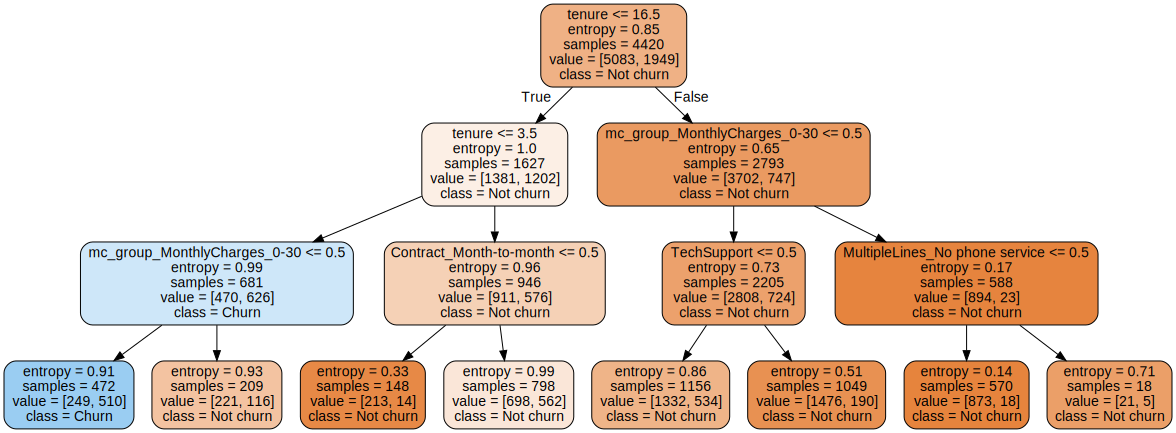

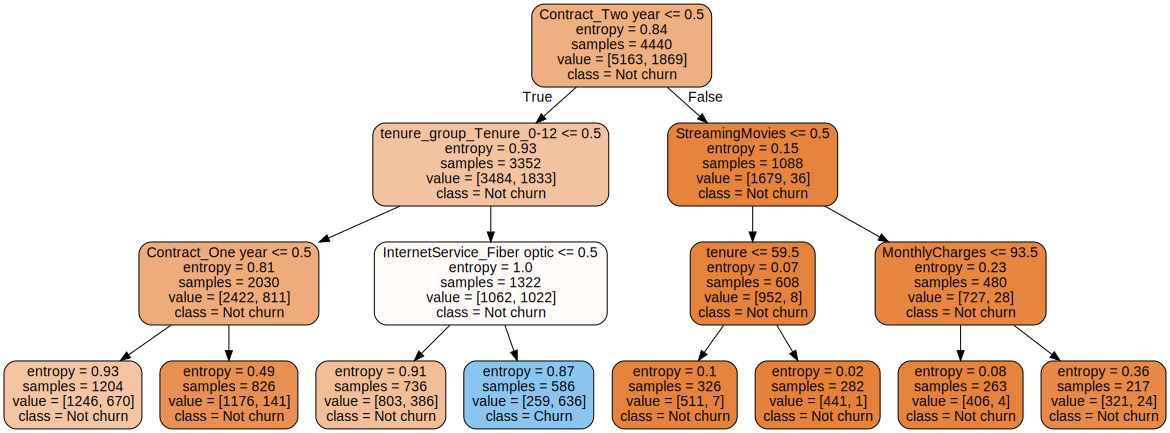

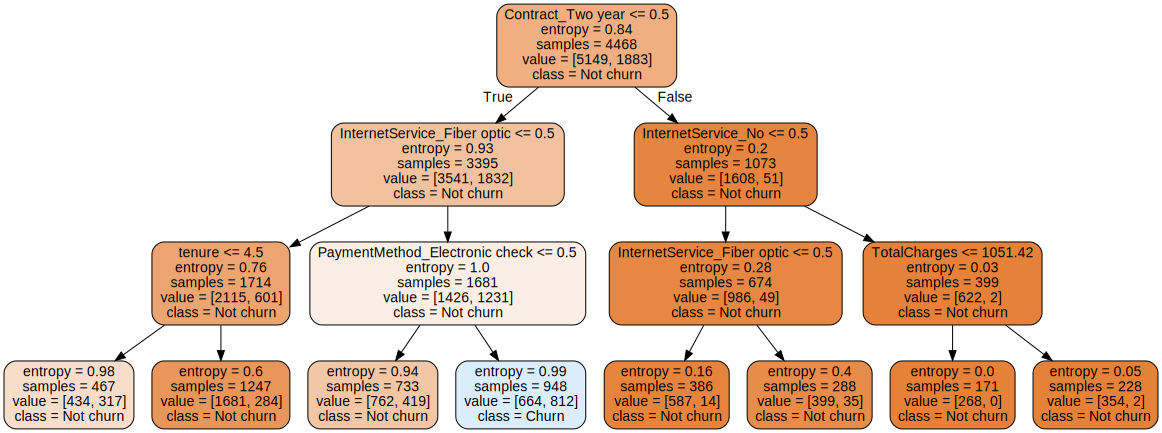

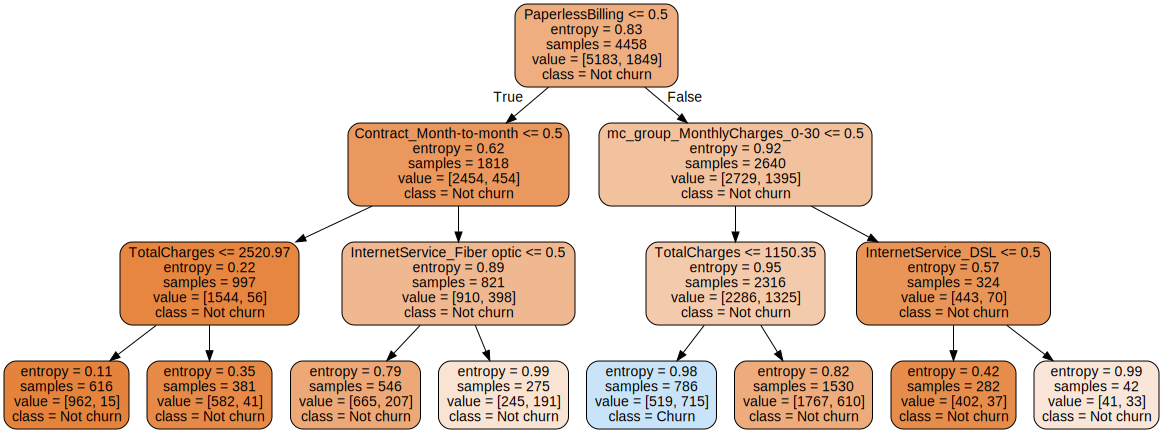

In [28]:
#making 10 trees with random forest.
n = np.arange(0,10).tolist()
cols1 = [ i for i in train_X.columns if i not in target_col + Id_col] 
for i in n :
    plot_tree_randomforest(cols1,10,i,3,"entropy",model_performance=False)

## <a id='5.14'>Bayesian Network</a>

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score
from yellowbrick.classifier import DiscriminationThreshold

df_telcom_og.drop(['gender', 'tenure', 'MonthlyCharges', 'TotalCharges'],axis=1,inplace=True)
#splitting train and test data 
train,test = train_test_split(df_telcom_og,test_size = .25 ,random_state = 111)
    
##seperating dependent and independent variables
cols    = [i for i in df_telcom_og.columns if i not in Id_col + target_col]
train_X = train[cols]
train_Y = train[target_col]
test_X  = test[cols]
test_Y  = test[target_col]

trainbn = pd.concat([train_X, train_Y], axis=1)

In [32]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator

# network construction
bn = BayesianModel([('Partner','Dependents'),     
        ('SeniorCitizen','Dependents'),
        
        ('Dependents','PhoneService'),
        ('PhoneService','MultipleLines_No'),
        ('PhoneService','MultipleLines_No phone service'),
        ('PhoneService','MultipleLines_Yes'),
        ('PhoneService','DeviceProtection'),
        ('PhoneService','TechSupport'),
        
        ('PhoneService','tenure_group_Tenure_0-12'),
        ('InternetService_DSL','tenure_group_Tenure_0-12'),
        ('InternetService_Fiber optic','tenure_group_Tenure_0-12'),
        ('InternetService_No','tenure_group_Tenure_0-12'),
        ('PhoneService','tenure_group_Tenure_12-24'),
        ('InternetService_DSL','tenure_group_Tenure_12-24'),
        ('InternetService_Fiber optic','tenure_group_Tenure_12-24'),
        ('InternetService_No','tenure_group_Tenure_12-24'),
        ('PhoneService','tenure_group_Tenure_24-48'),
        ('InternetService_DSL','tenure_group_Tenure_24-48'),
        ('InternetService_Fiber optic','tenure_group_Tenure_24-48'),
        ('InternetService_No','tenure_group_Tenure_24-48'),
        ('PhoneService','tenure_group_Tenure_48-60'),
        ('InternetService_DSL','tenure_group_Tenure_48-60'),
        ('InternetService_Fiber optic','tenure_group_Tenure_48-60'),
        ('InternetService_No','tenure_group_Tenure_48-60'),
        ('PhoneService','tenure_group_Tenure_gt_60'),
        ('InternetService_DSL','tenure_group_Tenure_gt_60'),
        ('InternetService_Fiber optic','tenure_group_Tenure_gt_60'),
        ('InternetService_No','tenure_group_Tenure_gt_60'),
        
        ('tenure_group_Tenure_0-12','Churn'),
        ('tenure_group_Tenure_12-24','Churn'),
        ('tenure_group_Tenure_24-48','Churn'),
        ('tenure_group_Tenure_48-60','Churn'),
        ('tenure_group_Tenure_gt_60','Churn'),
                    
        ('MultipleLines_No','mc_group_MonthlyCharges_0-30'),
        ('MultipleLines_No phone service','mc_group_MonthlyCharges_0-30'),
        ('MultipleLines_Yes','mc_group_MonthlyCharges_0-30'),
        ('DeviceProtection','mc_group_MonthlyCharges_0-30'),
        ('TechSupport','mc_group_MonthlyCharges_0-30'),
        ('MultipleLines_No','mc_group_MonthlyCharges_30-60'),
        ('MultipleLines_No phone service','mc_group_MonthlyCharges_30-60'),
        ('MultipleLines_Yes','mc_group_MonthlyCharges_30-60'),
        ('DeviceProtection','mc_group_MonthlyCharges_30-60'),
        ('TechSupport','mc_group_MonthlyCharges_30-60'),
        ('MultipleLines_No','mc_group_MonthlyCharges_60-90'),
        ('MultipleLines_No phone service','mc_group_MonthlyCharges_60-90'),
        ('MultipleLines_Yes','mc_group_MonthlyCharges_60-90'),
        ('DeviceProtection','mc_group_MonthlyCharges_60-90'),
        ('TechSupport','mc_group_MonthlyCharges_60-90'),
        ('MultipleLines_No','mc_group_MonthlyCharges_90-120'),
        ('MultipleLines_No phone service','mc_group_MonthlyCharges_90-120'),
        ('MultipleLines_Yes','mc_group_MonthlyCharges_90-120'),
        ('DeviceProtection','mc_group_MonthlyCharges_90-120'),
        ('TechSupport','mc_group_MonthlyCharges_90-120'),
                    
        
        ('Dependents','InternetService_DSL'),
        ('Dependents','InternetService_Fiber optic'),
        ('Dependents','InternetService_No'),
                    
        ('InternetService_DSL','DeviceProtection'),
        ('InternetService_Fiber optic','DeviceProtection'),
        ('InternetService_No','DeviceProtection'),
        ('InternetService_DSL','TechSupport'),
        ('InternetService_Fiber optic','TechSupport'),
        ('InternetService_No','TechSupport'),
                              
        ('InternetService_DSL','StreamingTV'),
        ('InternetService_Fiber optic','StreamingTV'),
        ('InternetService_No','StreamingTV'),
        ('InternetService_DSL','StreamingMovies'),
        ('InternetService_Fiber optic','StreamingMovies'),
        ('InternetService_No','StreamingMovies'),
        ('InternetService_DSL','OnlineSecurity'),
        ('InternetService_Fiber optic','OnlineSecurity'),
        ('InternetService_No','OnlineSecurity'),
        ('InternetService_DSL','OnlineBackup'),
        ('InternetService_Fiber optic','OnlineBackup'),
        ('InternetService_No','OnlineBackup'),
                    
        ('StreamingTV','mc_group_MonthlyCharges_0-30'),
        ('StreamingMovies','mc_group_MonthlyCharges_0-30'),
        ('OnlineSecurity','mc_group_MonthlyCharges_0-30'),
        ('OnlineBackup','mc_group_MonthlyCharges_0-30'),
        ('StreamingTV','mc_group_MonthlyCharges_30-60'),
        ('StreamingMovies','mc_group_MonthlyCharges_30-60'),
        ('OnlineSecurity','mc_group_MonthlyCharges_30-60'),
        ('OnlineBackup','mc_group_MonthlyCharges_30-60'),
        ('StreamingTV','mc_group_MonthlyCharges_60-90'),
        ('StreamingMovies','mc_group_MonthlyCharges_60-90'),
        ('OnlineSecurity','mc_group_MonthlyCharges_60-90'),
        ('OnlineBackup','mc_group_MonthlyCharges_60-90'),
        ('StreamingTV','mc_group_MonthlyCharges_90-120'),
        ('StreamingMovies','mc_group_MonthlyCharges_90-120'),
        ('OnlineSecurity','mc_group_MonthlyCharges_90-120'),
        ('OnlineBackup','mc_group_MonthlyCharges_90-120'),

                    
        ('SeniorCitizen','PaperlessBilling'),
        ('PaperlessBilling','PaymentMethod_Bank transfer (automatic)'),
        ('PaperlessBilling','PaymentMethod_Credit card (automatic)'),
        ('PaperlessBilling','PaymentMethod_Electronic check'),
        ('PaperlessBilling','PaymentMethod_Mailed check'),
        ('PaymentMethod_Bank transfer (automatic)','Contract_Month-to-month'),                    
        ('PaymentMethod_Bank transfer (automatic)','Contract_One year'),
        ('PaymentMethod_Bank transfer (automatic)','Contract_Two year'),
        ('PaymentMethod_Credit card (automatic)','Contract_Month-to-month'),                    
        ('PaymentMethod_Credit card (automatic)','Contract_One year'),
        ('PaymentMethod_Credit card (automatic)','Contract_Two year'),
        ('PaymentMethod_Electronic check','Contract_Month-to-month'),                    
        ('PaymentMethod_Electronic check','Contract_One year'),
        ('PaymentMethod_Electronic check','Contract_Two year'),
        ('PaymentMethod_Mailed check','Contract_Month-to-month'),                    
        ('PaymentMethod_Mailed check','Contract_One year'),
        ('PaymentMethod_Mailed check','Contract_Two year'),
        ('Contract_Month-to-month','mc_group_MonthlyCharges_0-30'),
        ('Contract_One year','mc_group_MonthlyCharges_0-30'),
        ('Contract_Two year','mc_group_MonthlyCharges_0-30'),
        ('Contract_Month-to-month','mc_group_MonthlyCharges_30-60'),
        ('Contract_One year','mc_group_MonthlyCharges_30-60'),
        ('Contract_Two year','mc_group_MonthlyCharges_30-60'),
        ('Contract_Month-to-month','mc_group_MonthlyCharges_60-90'),
        ('Contract_One year','mc_group_MonthlyCharges_60-90'),
        ('Contract_Two year','mc_group_MonthlyCharges_60-90'),
        ('Contract_Month-to-month','mc_group_MonthlyCharges_90-120'),
        ('Contract_One year','mc_group_MonthlyCharges_90-120'),
        ('Contract_Two year','mc_group_MonthlyCharges_90-120'), 
                    
        ('mc_group_MonthlyCharges_0-30','tc_group_TotalCharges_0-400'),
        ('mc_group_MonthlyCharges_30-60','tc_group_TotalCharges_0-400'),
        ('mc_group_MonthlyCharges_60-90','tc_group_TotalCharges_0-400'),
        ('mc_group_MonthlyCharges_90-120','tc_group_TotalCharges_0-400'),
        ('mc_group_MonthlyCharges_0-30','tc_group_TotalCharges_1400-4000'),
        ('mc_group_MonthlyCharges_30-60','tc_group_TotalCharges_1400-4000'),
        ('mc_group_MonthlyCharges_60-90','tc_group_TotalCharges_1400-4000'),
        ('mc_group_MonthlyCharges_90-120','tc_group_TotalCharges_1400-4000'),
        ('mc_group_MonthlyCharges_0-30','tc_group_TotalCharges_400-1400'),
        ('mc_group_MonthlyCharges_30-60','tc_group_TotalCharges_400-1400'),
        ('mc_group_MonthlyCharges_60-90','tc_group_TotalCharges_400-1400'),
        ('mc_group_MonthlyCharges_90-120','tc_group_TotalCharges_400-1400'),
        ('mc_group_MonthlyCharges_0-30','tc_group_TotalCharges_4000-9000'),
        ('mc_group_MonthlyCharges_30-60','tc_group_TotalCharges_4000-9000'),
        ('mc_group_MonthlyCharges_60-90','tc_group_TotalCharges_4000-9000'),
        ('mc_group_MonthlyCharges_90-120','tc_group_TotalCharges_4000-9000'),
        ('tc_group_TotalCharges_0-400','Churn'),
        ('tc_group_TotalCharges_400-1400','Churn'),
        ('tc_group_TotalCharges_1400-4000','Churn'),
        ('tc_group_TotalCharges_4000-9000','Churn')      
        ])

bn.fit(trainbn, estimator=MaximumLikelihoodEstimator)


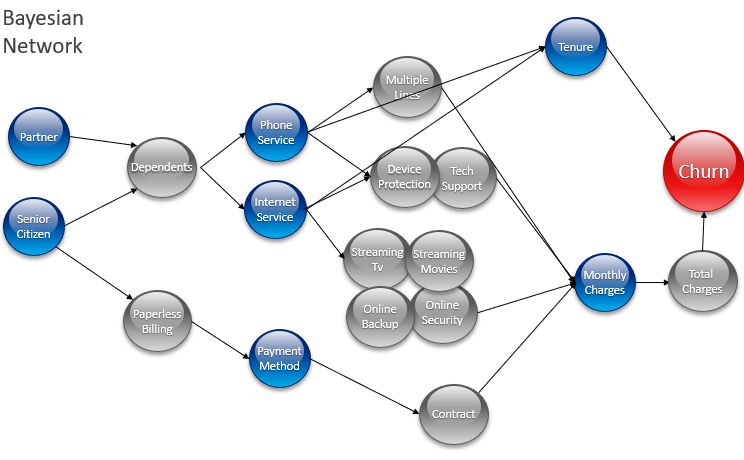

In [35]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(bn)

def get_query_result(infer, X_test):
    result = []
    variables = X_test.columns.tolist() # [:-1] to exclude last Var38 in this case
    for i in range(50): #len(X_test.values)): --- using range(5) to limit number of queries
        q = infer.query(variables=['Churn'], evidence=dict(zip(variables,list(map(int,X_test.values[i].tolist()))))) 
        if q.values[0] >= 0.5:
            result.append(0)
        else:
            result.append(1)
        print(q)
    return result

# infer.query(['Churn'])
y_pred = get_query_result(infer, test_X)

Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5093 |
+----------+--------------+
| Churn(1) |       0.4907 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 334.07it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7730 |
+----------+--------------+
| Churn(1) |       0.2270 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 334.21it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.9615 |
+----------+--------------+
| Churn(1) |       0.0385 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7586 |
+----------+--------------+
| Churn(1) |       0.2414 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.6953 |
+----------+--------------+
| Churn(1) |       0.3047 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.6003 |
+----------+--------------+
| Churn(1) |       0.3997 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.6953 |
+----------+--------------+
| Churn(1) |       0.3047 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.65it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.6953 |
+----------+--------------+
| Churn(1) |       0.3047 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7762 |
+----------+--------------+
| Churn(1) |       0.2238 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5337 |
+----------+--------------+
| Churn(1) |       0.4663 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.8668 |
+----------+--------------+
| Churn(1) |       0.1332 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 500.75it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5337 |
+----------+--------------+
| Churn(1) |       0.4663 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 503.76it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5980 |
+----------+--------------+
| Churn(1) |       0.4020 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 250.57it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5463 |
+----------+--------------+
| Churn(1) |       0.4537 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.65it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.6707 |
+----------+--------------+
| Churn(1) |       0.3293 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7730 |
+----------+--------------+
| Churn(1) |       0.2270 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.53it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7541 |
+----------+--------------+
| Churn(1) |       0.2459 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 334.18it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.9615 |
+----------+--------------+
| Churn(1) |       0.0385 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 200.44it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5341 |
+----------+--------------+
| Churn(1) |       0.4659 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.9827 |
+----------+--------------+
| Churn(1) |       0.0173 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 502.07it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5980 |
+----------+--------------+
| Churn(1) |       0.4020 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 500.33it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5337 |
+----------+--------------+
| Churn(1) |       0.4663 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5341 |
+----------+--------------+
| Churn(1) |       0.4659 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 500.69it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.6953 |
+----------+--------------+
| Churn(1) |       0.3047 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.9643 |
+----------+--------------+
| Churn(1) |       0.0357 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.6003 |
+----------+--------------+
| Churn(1) |       0.3997 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 500.27it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5337 |
+----------+--------------+
| Churn(1) |       0.4663 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.53it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5071 |
+----------+--------------+
| Churn(1) |       0.4929 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 500.93it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.6953 |
+----------+--------------+
| Churn(1) |       0.3047 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 500.75it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5662 |
+----------+--------------+
| Churn(1) |       0.4338 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.59it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5232 |
+----------+--------------+
| Churn(1) |       0.4768 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.8961 |
+----------+--------------+
| Churn(1) |       0.1039 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 397.79it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.6707 |
+----------+--------------+
| Churn(1) |       0.3293 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.9615 |
+----------+--------------+
| Churn(1) |       0.0385 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5036 |
+----------+--------------+
| Churn(1) |       0.4964 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.77it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5337 |
+----------+--------------+
| Churn(1) |       0.4663 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.77it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7586 |
+----------+--------------+
| Churn(1) |       0.2414 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 500.99it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.9615 |
+----------+--------------+
| Churn(1) |       0.0385 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.9643 |
+----------+--------------+
| Churn(1) |       0.0357 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.53it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5662 |
+----------+--------------+
| Churn(1) |       0.4338 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 333.94it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.6953 |
+----------+--------------+
| Churn(1) |       0.3047 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 500.87it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.6707 |
+----------+--------------+
| Churn(1) |       0.3293 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 334.29it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7586 |
+----------+--------------+
| Churn(1) |       0.2414 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 1003.18it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.6707 |
+----------+--------------+
| Churn(1) |       0.3293 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.6003 |
+----------+--------------+
| Churn(1) |       0.3997 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 498.85it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5341 |
+----------+--------------+
| Churn(1) |       0.4659 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.59it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.6953 |
+----------+--------------+
| Churn(1) |       0.3047 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5259 |
+----------+--------------+
| Churn(1) |       0.4741 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.77it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5071 |
+----------+--------------+
| Churn(1) |       0.4929 |
+----------+--------------+


Eliminating: tc_group_TotalCharges_4000-9000: 100%|█████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.6003 |
+----------+--------------+
| Churn(1) |       0.3997 |
+----------+--------------+


In [36]:
y_pred

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [55]:
df20 = df_telcom_og[['Contract_Month-to-month', 
 'Contract_Two year', 
 'tenure_group_Tenure_0-12', 
 'InternetService_Fiber optic', 
 'PaymentMethod_Electronic check', 
 'customerID', 
 'tenure_group_Tenure_gt_60', 
 'InternetService_No', 
 'mc_group_MonthlyCharges_0-30',
 'tc_group_TotalCharges_0-400',
 'Contract_One year',
 'PaperlessBilling',
 'OnlineSecurity', 
 'TechSupport', 
 'SeniorCitizen',
 'Dependents', 
 'tc_group_TotalCharges_4000-9000', 
 'PaymentMethod_Credit card (automatic)',
 'Partner', 
 'tenure_group_Tenure_48-60',
 'Churn']]

#splitting train and test data 
train2,test2 = train_test_split(df20,test_size = .25 ,random_state = 111)
    
##seperating dependent and independent variables
cols    = [i for i in df20.columns if i not in Id_col + target_col]
train2_X = train2[cols]
train2_Y = train2[target_col]
test2_X  = test2[cols]
test2_Y  = test2[target_col]

train2bn = pd.concat([train2_X, train2_Y], axis=1)

In [59]:
bn_top20 = BayesianModel([
#         ('customerID','SeniorCitizen'), 
#         ('customerID','Partner'), 
        ('Partner','Dependents'),     
        ('SeniorCitizen','Dependents'),
        
        ('Dependents','InternetService_Fiber optic'),
        ('Dependents','InternetService_No'),
    
        ('InternetService_Fiber optic','tenure_group_Tenure_0-12'),
        ('InternetService_No','tenure_group_Tenure_0-12'),
        ('InternetService_Fiber optic','tenure_group_Tenure_48-60'),
        ('InternetService_No','tenure_group_Tenure_48-60'),
        ('InternetService_Fiber optic','tenure_group_Tenure_gt_60'),
        ('InternetService_No','tenure_group_Tenure_gt_60'),
        
        ('tenure_group_Tenure_0-12','Churn'),
        ('tenure_group_Tenure_48-60','Churn'),
        ('tenure_group_Tenure_gt_60','Churn'),

        ('InternetService_Fiber optic','TechSupport'),
        ('InternetService_No','TechSupport'),
        ('InternetService_Fiber optic','OnlineSecurity'),
        ('InternetService_No','OnlineSecurity'),
          
        ('TechSupport','mc_group_MonthlyCharges_0-30'),
        ('OnlineSecurity','mc_group_MonthlyCharges_0-30'),
    
                    
        ('SeniorCitizen','PaperlessBilling'),
      
        ('PaperlessBilling','PaymentMethod_Credit card (automatic)'),
        ('PaperlessBilling','PaymentMethod_Electronic check'),
        
        ('PaymentMethod_Credit card (automatic)','Contract_Month-to-month'),  
        ('PaymentMethod_Credit card (automatic)','Contract_One year'),
        ('PaymentMethod_Credit card (automatic)','Contract_Two year'),
        ('PaymentMethod_Electronic check','Contract_Month-to-month'), 
        ('PaymentMethod_Electronic check','Contract_One year'),
        ('PaymentMethod_Electronic check','Contract_Two year'),
      
        ('Contract_Month-to-month','mc_group_MonthlyCharges_0-30'),
        ('Contract_One year','mc_group_MonthlyCharges_0-30'),  
        ('Contract_Two year','mc_group_MonthlyCharges_0-30'),  
        ('mc_group_MonthlyCharges_0-30','tc_group_TotalCharges_0-400'),
        ('mc_group_MonthlyCharges_0-30','tc_group_TotalCharges_4000-9000'),

        ('tc_group_TotalCharges_0-400','Churn'),
        ('tc_group_TotalCharges_4000-9000','Churn')      
        ])

bn_top20.fit(train2bn, estimator=MaximumLikelihoodEstimator)

In [62]:
infer2 = VariableElimination(bn_top20)

def get_query_result(infer, X_test):
    result = []
    variables = X_test.columns.tolist() # [:-1] to exclude last Var38 in this case
    for i in range(50): #len(X_test.values)): --- using range(5) to limit number of queries
        q = infer.query(variables=['Churn'], evidence=dict(zip(variables,list(map(int,X_test.values[i].tolist()))))) 
        if q.values[0] >= 0.5:
            result.append(0)
        else:
            result.append(1)
        print(q)
    return result

y_pred = get_query_result(infer2, test2_X)
y_pred

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5094 |
+----------+--------------+
| Churn(1) |       0.4906 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7707 |
+----------+--------------+
| Churn(1) |       0.2293 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7707 |
+----------+--------------+
| Churn(1) |       0.2293 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.9179 |
+----------+--------------+
| Churn(1) |       0.0821 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7707 |
+----------+--------------+
| Churn(1) |       0.2293 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.9179 |
+----------+--------------+
| Churn(1) |       0.0821 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7707 |
+----------+--------------+
| Churn(1) |       0.2293 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7707 |
+----------+--------------+
| Churn(1) |       0.2293 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7707 |
+----------+--------------+
| Churn(1) |       0.2293 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5341 |
+----------+--------------+
| Churn(1) |       0.4659 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.9865 |
+----------+--------------+
| Churn(1) |       0.0135 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5341 |
+----------+--------------+
| Churn(1) |       0.4659 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7707 |
+----------+--------------+
| Churn(1) |       0.2293 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7707 |
+----------+--------------+
| Churn(1) |       0.2293 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7759 |
+----------+--------------+
| Churn(1) |       0.2241 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7707 |
+----------+--------------+
| Churn(1) |       0.2293 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7707 |
+----------+--------------+
| Churn(1) |       0.2293 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7707 |
+----------+--------------+
| Churn(1) |       0.2293 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5341 |
+----------+--------------+
| Churn(1) |       0.4659 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.9865 |
+----------+--------------+
| Churn(1) |       0.0135 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7707 |
+----------+--------------+
| Churn(1) |       0.2293 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5341 |
+----------+--------------+
| Churn(1) |       0.4659 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5341 |
+----------+--------------+
| Churn(1) |       0.4659 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7707 |
+----------+--------------+
| Churn(1) |       0.2293 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.9258 |
+----------+--------------+
| Churn(1) |       0.0742 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.9179 |
+----------+--------------+
| Churn(1) |       0.0821 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5341 |
+----------+--------------+
| Churn(1) |       0.4659 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5094 |
+----------+--------------+
| Churn(1) |       0.4906 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7707 |
+----------+--------------+
| Churn(1) |       0.2293 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7759 |
+----------+--------------+
| Churn(1) |       0.2241 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7707 |
+----------+--------------+
| Churn(1) |       0.2293 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.9258 |
+----------+--------------+
| Churn(1) |       0.0742 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7759 |
+----------+--------------+
| Churn(1) |       0.2241 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7707 |
+----------+--------------+
| Churn(1) |       0.2293 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5094 |
+----------+--------------+
| Churn(1) |       0.4906 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5341 |
+----------+--------------+
| Churn(1) |       0.4659 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.9179 |
+----------+--------------+
| Churn(1) |       0.0821 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7707 |
+----------+--------------+
| Churn(1) |       0.2293 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.9258 |
+----------+--------------+
| Churn(1) |       0.0742 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7759 |
+----------+--------------+
| Churn(1) |       0.2241 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7707 |
+----------+--------------+
| Churn(1) |       0.2293 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7759 |
+----------+--------------+
| Churn(1) |       0.2241 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.9179 |
+----------+--------------+
| Churn(1) |       0.0821 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7759 |
+----------+--------------+
| Churn(1) |       0.2241 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.9179 |
+----------+--------------+
| Churn(1) |       0.0821 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5341 |
+----------+--------------+
| Churn(1) |       0.4659 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.7707 |
+----------+--------------+
| Churn(1) |       0.2293 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5341 |
+----------+--------------+
| Churn(1) |       0.4659 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.5094 |
+----------+--------------+
| Churn(1) |       0.4906 |
+----------+--------------+


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


+----------+--------------+
| Churn    |   phi(Churn) |
+==========+==============+
| Churn(0) |       0.9179 |
+----------+--------------+
| Churn(1) |       0.0821 |
+----------+--------------+


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]